In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

import os
import pyworld
import librosa
import time
import matplotlib.pyplot as plt

from preprocess import *
from model import *

torch.manual_seed(0)
np.random.seed(0)

In [2]:
model_dir = "./model/model_mc32_fr1024"
model_name = "model_mc32_fr1024"

data_dir = "./data/voice_data"
# voice_dir = ["F4", "F5", "F6", "M2"]
voice_dir = ["test01", "test02"]

_from = voice_dir.index("test01")
_to = voice_dir.index("test02")

# output_dir = "./converted_voices/model_mc32_fr1024_training_progress"
output_dir = "./converted_voices/test"

# figure_dir = "./figure/model_mc32_fr1024"
figure_dir = "./figure/test"

In [3]:
if (False):
    for v in voice_dir:
        print("Preprocess: " + v)
        preprocess_voice(os.path.join(data_dir, v), v)

In [4]:
num_epochs = 10 #10000
batch_size = 2
learning_rate =1e-4 

sampling_rate = 16000
num_mcep = 36
frame_period = 5.0
n_frames = 1024 

losses = []
loss_num = 0

In [5]:
def model_save(model, model_dir, model_name):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(model.state_dict(), os.path.join(model_dir, model_name))
    
def model_load(model_dir, model_name):
    model = ACVAE()
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))

In [6]:
def save_figure(losses, epoch):        
    if not os.path.exists(figure_dir):
            os.makedirs(figure_dir)
    losses = np.array(losses)
    losses = losses.reshape(-1, 4)
    x = np.linspace(0, len(losses), len(losses))
    losses_label = ("L1", "KLD", "AC_1", "AC_2")
    plt.figure()
    plt.plot(x, losses[:,0], label=losses_label[0])
    plt.plot(x, losses[:,1], label=losses_label[1])
    plt.plot(x, losses[:,2], label=losses_label[2])
    plt.plot(x, losses[:,3], label=losses_label[3])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)
    plt.savefig(figure_dir + "/" + "epoch_{:05}".format(epoch) + ".png")

In [7]:
def data_load(batchsize = 1, s = -1, t = -1):
    x = []
    label = []
    for i in range(batchsize):
        if (s == -1):
            label_num = np.random.randint(len(voice_dir))
        else:
            label_num = s
        voice_path = os.path.join(data_dir, voice_dir[label_num])
        files = os.listdir(voice_path)
        
        frames = 0
        while frames < n_frames:
            
            file = ""
            while file.count("wav") == 0:
                file = np.random.choice(files)
            wav, _ = librosa.load(os.path.join(voice_path, file), sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            frames = np.shape(coded_sp_transposed)[1]
            
        mcep_normalization_params = np.load(os.path.join(voice_path, "mcep_"+voice_dir[label_num]+".npz"))
        mcep_mean = mcep_normalization_params['mean']
        mcep_std = mcep_normalization_params['std']
        coded_sp_norm = (coded_sp_transposed - mcep_mean) / mcep_std
            
        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames
            
        x.append(coded_sp_norm[:,start_:end_])
        label.append(label_num)

    return torch.Tensor(x).view(batchsize, 1, num_mcep, n_frames), torch.Tensor(label)

In [8]:
def test_one_file(model, s_label, t_label, epoch):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    voice_path_s = os.path.join(data_dir, voice_dir[s_label])
    voice_path_t = os.path.join(data_dir, voice_dir[t_label])
    
    files = os.listdir(voice_path_s)
    file = ""
    while file.count("wav") == 0:
        file = np.random.choice(files)
        
    wav, _ = librosa.load(os.path.join(voice_path_s, file), sr = sampling_rate, mono = True)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
    coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
    coded_sp_transposed = coded_sp.T
    
    mcep_normalization_params_s = np.load(os.path.join(voice_path_s, "mcep_"+voice_dir[s_label]+".npz"))
    mcep_mean_s = mcep_normalization_params_s['mean']
    mcep_std_s = mcep_normalization_params_s['std']    
    mcep_normalization_params_t = np.load(os.path.join(voice_path_t, "mcep_"+voice_dir[t_label]+".npz"))
    mcep_mean_t = mcep_normalization_params_t['mean']
    mcep_std_t = mcep_normalization_params_t['std']
    
    coded_sp_norm = (coded_sp_transposed - mcep_mean_s) / mcep_std_s
    
    x = torch.Tensor(coded_sp_norm).view(1, 1, coded_sp_norm.shape[0], coded_sp_norm.shape[1])
    
    label_s_tensor = torch.Tensor(np.array([s_label])).view(1, 1)
    label_t_tensor = torch.Tensor(np.array([t_label])).view(1, 1)
    
    mu_enc, logvar_enc = model.encode(x, label_s_tensor)
    z_enc = model.reparameterize(mu_enc, logvar_enc)
    mu_dec, logvar_dec = model.decode(z_enc, label_t_tensor)
    z_dec = model.reparameterize(mu_dec, logvar_dec)
    z_dec = z_dec.data.numpy().reshape((coded_sp_norm.shape[0], coded_sp_norm.shape[1]))
    
    coded_sp_converted = z_dec * mcep_std_t + mcep_mean_t
    
    logf0s_normalization_params_s = np.load(os.path.join(voice_path_s, "log_f0_"+voice_dir[s_label]+".npz"))
    logf0s_mean_s = logf0s_normalization_params_s['mean']
    logf0s_std_s = logf0s_normalization_params_s['std']
    logf0s_normalization_params_t = np.load(os.path.join(voice_path_t, "log_f0_"+voice_dir[t_label]+".npz"))
    logf0s_mean_t = logf0s_normalization_params_t['mean']
    logf0s_std_t = logf0s_normalization_params_t['std']
    
    f0_converted = pitch_conversion(f0 = f0, mean_log_src = logf0s_mean_s, std_log_src = logf0s_std_s, mean_log_target = logf0s_mean_t, std_log_target = logf0s_std_t)
    
    coded_sp_converted = coded_sp_converted.T
    coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
    decoded_sp_converted = world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
    wav_transformed = world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
    librosa.output.write_wav(os.path.join(output_dir, str(epoch) + "_" + os.path.basename(file)), wav_transformed, sampling_rate)
    
    print("Test")
    print(file)
    print("Converted: " + voice_dir[s_label] + " -> " + voice_dir[t_label])

cpu
Epoch: 1
Time Elapsed for one epoch: 00:00:04
Epoch: 2
Time Elapsed for one epoch: 00:00:04
Epoch: 3
Time Elapsed for one epoch: 00:00:04
Epoch: 4
Time Elapsed for one epoch: 00:00:04
Epoch: 5
Time Elapsed for one epoch: 00:00:05
Epoch: 6
Time Elapsed for one epoch: 00:00:04
Epoch: 7
Time Elapsed for one epoch: 00:00:04
Epoch: 8
Time Elapsed for one epoch: 00:00:04
Epoch: 9
Time Elapsed for one epoch: 00:00:04
Epoch: 10
Time Elapsed for one epoch: 00:00:04


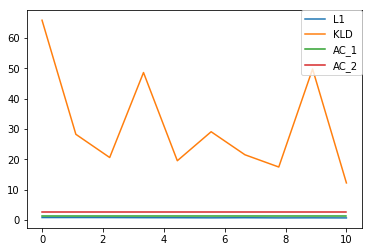

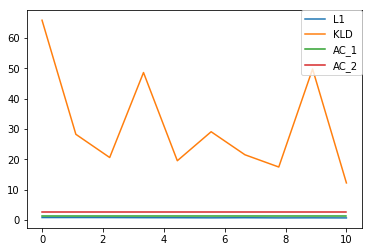

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ACVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()

for epoch in range(num_epochs):
    epoch += 1
    
    start_time = time.time()

    print('Epoch: %d' % epoch)

    x_, label_ = data_load(batch_size)
    optimizer.zero_grad()
    loss, loss_list = model.calc_loss(x_, label_)
    loss.backward()
    losses.append(loss_list)
    optimizer.step()
    loss_num += 1
    
    if epoch % 100 == 0:
        test_one_file(model, _from, _to, epoch)
    if epoch % 100 == 0:
        model_save(model, model_dir, model_name)
    if epoch % 2000 == 0:
        model_save(model, model_dir, model_name + "_" + str(epoch))

    if epoch % 10 == 0:
        save_figure(losses, epoch)
    
    elapsed_time = time.time() - start_time
    print('Time Elapsed for one epoch: %02d:%02d:%02d' % (elapsed_time // 3600, (elapsed_time % 3600 // 60), (elapsed_time % 60 // 1)))

model_save(model, model_dir, model_name)

save_figure(losses, epoch)


In [10]:
a, b= data_load(2)

In [11]:
np.shape(a)

torch.Size([2, 1, 36, 1024])

(array([   54.,   257.,  1420.,  4695.,  8712., 10954.,  7297.,  2714.,
          674.,    87.]),
 array([-4.02091026, -3.25785735, -2.49480443, -1.73175151, -0.9686986 ,
        -0.20564568,  0.55740724,  1.32046015,  2.08351307,  2.84656599,
         3.6096189 ]),
 <a list of 10 Patch objects>)

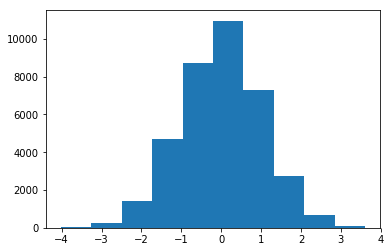

In [12]:
plt.hist(np.array(a[0,0].flatten()))

In [13]:
losses[5]

[0.730417013168335, 29.107553482055664, 1.3815511465072632, 2.7631022930145264]